# Polynomial Regression with Flux/Zygote

Chapter 1 of any machine learning book always has a short paragraph on linear regression.

Toolkits of the like of TensorFlow or Flux are useful in their ability to perform complex derivatives and orchestrate training algorithms on complex nonlinear and deep models. However, the focus nowadays is on optimizing the hottest neural network with minibatched stochastic gradient descent, which misses the rest of the field of optimization. There are plently more classes of models algorithmsthat this programming approach can help us perform and develop. It's important that any automatic ML/Deep Learning package be able to derive these simple models. We can take the hard work out of deriving and implementing newer non-neural network models too.

A linear model is fit by:
\begin{equation}
f(x) = W basis(x) + b
\end{equation}
where "basis" is the The set $basis(x)=\{x\}$ is a linear model. We'll be doing polynomials where $basis(p)(x)=\{x,x^2,...x^p\}$. The solution is the well known linear least squares problem,
\begin{equation}
P = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T y
\end{equation}
where $X$ is a rectangular matrix depending on the basis set and data, $X_{ij} = basis_i(x_j)$.

We're going to take a different approach: instead of starting with the least-squares equation and deriving the matrix equation, we're going to define **the code for a function** and perform source code transformations on to get the **program** we need that performs the regression.

To get this to work, we have to use a bleeding edge branch of Zygote:
```juia
] add Zygote#mutate
```
I'm also using a macro for generating polynomial expansions, whose source can be found here:
[https://github.com/afqueiruga/AfqsJuliaUtil.jl/blob/master/AfqsJuliaUtil.jl](https://github.com/afqueiruga/AfqsJuliaUtil.jl/blob/master/AfqsJuliaUtil.jl)

In [1]:
include("./AfqsJuliaUtil.jl")
using .AfqsJuliaUtil

First, let's make a simple dataset with known expected values:

In [2]:
dat_x = collect(1:0.1:10);
dat_y = 0.1*dat_x.^2 .+ 5 .+ 0.15*rand(length(dat_x));
dat_x = reshape(dat_x,(1,:));
dat_y = reshape(dat_y,(1,:));

We use the arguments format for parameters, in which they get passed through the function, rather than the implicit parameters format. A model has three arguments: hyperparameters, parameters, and input features:
\begin{equation}
f_{hyper}(x;params)
\end{equation}
Conceptually, I prefer this way of thinking about it, but juggling the arguments is complicated for the model developer. 

In [3]:
poly = AfqsJuliaUtil.@polynomial_function(1,3)
P0 = rand(4)
f(x,P) = P[1:3]'*poly(x).+P[4];

With this "simple" expression, we will use Flux and Zygote to optimize the values of the parameters. When we derive the original form for linear regression, we're optimizing the squared error loss over all data points:
\begin{equation}
P = \arg \min_P \left\| y-f(x;P)\right\|_2
\end{equation}

In [4]:
using Flux, Zygote, Plots
loss(x,y, P) = Flux.mse(y,f(x,P))

loss (generic function with 1 method)

We check that it works:

In [5]:
loss(dat_x,dat_y, P0)

153643.90926297026

Finding the minimum is the same as finding a root,
\begin{equation}
\frac{\partial L}{\partial P} = 0
\end{equation}
which can be solved with the following single step of Newton's method:
\begin{equation}
\left[\frac{\partial^2 L}{\partial P^2}\right]\Delta P = -\frac{\partial L}{\partial P}
\end{equation}
So... let's just type that! 

In [6]:
grad_fwd(x) = Zygote.forward_jacobian( (P->loss(dat_x,dat_y, P)), x )[2];
hess_fwd(x) = Zygote.forward_jacobian( gradx_fwd, x );

**Note:** Ideally, we would want to backward differentiate the loss because it's more efficient when $N_{outputs} \ll N_{inputs}$. I'm note sure which algorithm would be better for the derivative of the gradient; probably forward differentiation. However, Zygote still has trouble forward differentiating something that was backward differentiated:

In [7]:
#gradx(x) = Zygote.gradient( (P->loss(dat_x,dat_y, P)), x )[1]
#hessx_fwd(x) = Zygote.forward_jacobian( grad, x );

To get the matrix and right-hand-side, we evaluate it:

In [8]:
R,K=hess_fwd(P0)

([4385.54; 36711.5; 3.1605e5; 545.084], [74.3 560.45 4506.19 11.0; 560.45 4506.19 37738.1 74.3; 4506.19 37738.1 3.25071e5 560.45; 11.0 74.3 560.45 2.0])

Note how the gradient (R) is the same as the backward differentiated case.

To determine our parameters, we solve the resulting system of equations:

In [9]:
ΔP = K\R;
P = P0 - ΔP

4×1 Array{Float64,2}:
  0.005753081858799192 
  0.09952045013819949  
 -1.7712223406740613e-5
  5.067237452360866    

Notice how we recover `P[2]==0.1` and `P[4]==5`. We can verify that it looks right:

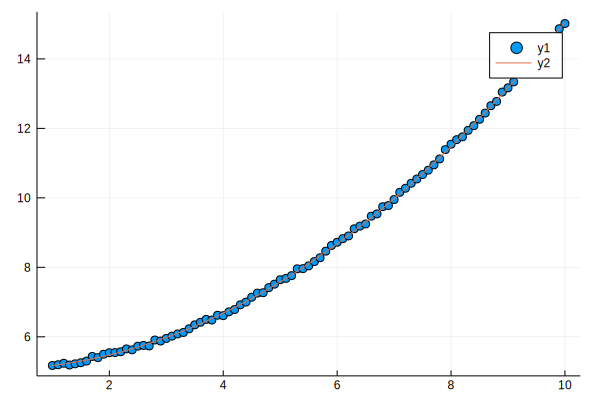

In [10]:
scatter(dat_x',dat_y')
plot!(dat_x',f(dat_x,P)')

## Why do we want to do this?


1. Assert that our deep learning tools can capture more basic methods,
2. Easily mplement new training methods that aren't just variations on stochastic gradient descent, and are possible application-specific,
3. Implement new layers in natural, compiled code, that possibly don't have neat mathematical descriptions.

Note how the entirity of linear regression was implemented in six lines of code, without sacrificing either expressibility or performance. I didn't have to do anything at all by hand beyond expressing the program that implemented the polynomial expansion. To be fair, my basis implementation is a little out-there due to the macro usage to precompute the combinatorics.